### 1.0 Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import datetime as dt
import geopandas as gpd #using this for mapping
from shapely.geometry import Point, Polygon #using this for mapping
from math import radians, cos, sin, asin, sqrt #using this for calculating the distance between points

### 2.0 Load Data

Loading in the cleaned, exported data from my data wrangling step.

In [28]:
#load trees data we exported in the prior step
trees_data = pd.read_csv('../data/data_outputs/seattle_trees.csv')

#load climate data we exported in the prior step
climate_data = pd.read_csv('../data/data_outputs/washington_climate_normals.csv')

#### 2.1 Precipitation Data

After testing this out with climate normals data, I only ended up with 3 useful stations for data. So while I was excited to have the 'normals' which is averages over a 15-20 year period, I want to now test pulling in some other data I found.
\
\
The Community Collaborative Rain, Hail, & Snow Network has some great tools to access data. Unfortunately, it is only for the 2022 calendar year. I don't love that, but I think it will give me more useful datapoints to and make the analysis more valuable.
\
\
When pulling this data, I filtered down to all available weather stations in King County, Washington, which includes the Seattle proper.
\
\
https://merbgai.cocorahs.org/Stations/ListStations.aspx

In [55]:
prcp_22 = pd.read_excel('../data/precip_2022.xlsx', sheet_name=0)
print(prcp_22.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB
None


In [56]:
prcp_22.head(3)

,Station Number,Station Name,Daily Precipitation Sum MM,Multi-Day Precipitation mm,Total Precipitation mm,Daily Snow Sum cm,# of Reports,Latitude,Longitude,Multi-Day Overlap Warning
0,WA-KG-3,Lake Forest Park 0.4 W,1111.2,NaN,1111.2,0.0,365,47.763558,-122.293917,NaN
1,WA-KG-4,Renton 3.2 E,149.1,NaN,149.1,0.0,21,47.484508,-122.127169,NaN
2,WA-KG-5,Mercer Island 1.5 NW,1043.4,NaN,1043.4,8.4,365,47.585900,-122.250900,NaN


**Observations**
\
\
The 'Total Precipitation mm' column should be the combination of the dailiy and multi-day column and the field we use. There is no multi-day column for snow, so that will be the column we can use for snow data.
\
\
I will need to confirm latitude & longitude data is complete. I also want to do some renaming of columns to make them a little more straight forward. So far what I've seen from the data, I don't need to worry about the multi-day 'warning', as I believe it is cumulative and not duplicative. I also think I'll convert the cm of snow into mm to match the precipitation. Go metric system!

### 3.0 Explore and Combine Data

The first step I have in mind is creating a field that maps each trees to its nearest weather station from my climate normals data.

#### 3.1 Tie Together The Two Dataframes Using Lat-Lon

##### 3.1.1 Rename Fields

In [31]:
#Need a reminder of my fields
trees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162080 entries, 0 to 162079
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   longitude_coordinate       162080 non-null  float64
 4   latitude_coordinate        162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
dtypes: float64(5), object(5)
memory usage: 12.4+ MB


In [57]:
prcp_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB


In [58]:
#Rename lat-long field in trees data to signify it is from this datasource. I could do this on a merge later, but I like to keep them seperate.
trees_data.rename(columns = {'longitude_coordinate': 'long_trees', 'latitude_coordinate': 'lat_trees'}, inplace=True)
#climate_data.rename(columns = {'LONGITUDE': 'long_climate', 'LATITUDE': 'lat_climate'}, inplace=True) leaving this in place incase I want to incorporate this data again later.

In [60]:
#Now I want to go through the precipitation data and rename the fields to be more Python friendly
prcp_22.rename(columns ={'Station Number': 'station_id', 'Station Name': 'station_name', 'Daily Precipitation Sum MM': 'daily_prcp_mm',
                         'Multi-Day Precipitation mm': 'multi_day_prcp_mm', 'Total Precipitation mm': 'total_prcp_mm',
                         'Daily Snow Sum cm': 'daily_snow_cm', '# of Reports': 'reports_#', 'Latitude': 'lat_prcp',
                         'Longitude': 'long_prcp', 'Multi-Day Overlap Warning': 'md_overlap'}, inplace=True)

#verify the names stuck
prcp_22.columns

Index(['station_id', 'station_name', 'daily_prcp_mm', 'multi_day_prcp_mm',
       'total_prcp_mm', 'daily_snow_cm', 'reports_#', 'lat_prcp', 'long_prcp',
       'md_overlap'],
      dtype='object')

##### 3.1.2 Assign Each Tree Record a Unique ID

I'm thinking in order to map back into our dataframe the closest station, I'll need to do it off a primary key and I'd rather not do that just off the location.

In [34]:

#Assign the key numerically, using the index number +1 (to exclude 0)
trees_data['tree_id'] = trees_data.index+1

In [35]:
#let's also change this to an object
trees_data['tree_id'] = trees_data['tree_id'].astype(object)

In [36]:
#Double check values are unique
trees_data['tree_id'].value_counts()

1         1
108057    1
108050    1
108051    1
108052    1
         ..
54028     1
54029     1
54030     1
54031     1
162080    1
Name: tree_id, Length: 162080, dtype: int64

In [37]:
#double check the id is an object now.
trees_data.dtypes

planted_date                  object
most_recent_observation       object
common_name                   object
long_trees                   float64
lat_trees                    float64
diameter_breast_height_CM    float64
condition                     object
native                        object
age_at_obs                   float64
condition_index              float64
tree_id                       object
dtype: object

##### 3.1.3 Define Functions

In [ ]:
def dist_b_points(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees). 
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [ ]:
def flag_nearest(lat, long):
    """ 
    Label the closest weather station using the reults of the dist_b_points function.
    I want to research and test this more. It seems weird to me that we specify the fields and df in the function, rather than use dynamic inputs.
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = climate_data.apply(
        lambda row: dist_b_points(lat, long, row['lat_climate'], row['long_climate']), axis = 1)
    return climate_data.loc[distances.idxmin(), 'STATION']

##### 3.1.4 Map the Nearest Station to Each Tree Record

In [38]:
trees_data['nearest_station'] = trees_data.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees']), axis=1)

In [39]:
trees_data['nearest_station'].value_counts()

USW00094290    100326
USW00024234     60464
USW00094248      1290
Name: nearest_station, dtype: int64

I'm surprised this only mapped in 3 location as the nearest. Let's merge in the rest of the climate data and see if this makes sense.

##### 3.1.5 Merge Datasets Into a Single Table

In [40]:
#left join on the station_id to create a master df to continue with my EDA.
trees_climate_all = pd.merge(trees_data, climate_data, left_on='nearest_station', right_on='STATION', how='left')

In [41]:
#check which stations came back, we'll use the station id later to split out for our map
trees_climate_all[['NAME','STATION']].value_counts()

NAME                         STATION    
SEATTLE SAND PT WSFO, WA US  USW00094290    100326
SEATTLE BOEING FLD, WA US    USW00024234     60464
RENTON MUNI AP, WA US        USW00094248      1290
dtype: int64

##### 3.1.6 Validate Visually

I want to plot both the stations an the trees on the same plot/map to see if these make sense visually.

In [42]:
crs = {'init': 'epsg:4326'} #standardization for geo data
geometry1 = [Point(xy) for xy in zip(trees_data['long_trees'], trees_data['lat_trees'])] #create points for trees location
geometry2 = [Point(xy) for xy in zip(climate_data['long_climate'], climate_data['lat_climate'])] #create points for weather stations

#check the formatting and values of the points
print(geometry1[:3]) 
print(geometry2[:3])

[<POINT (-122.282 47.635)>, <POINT (-122.31 47.598)>, <POINT (-122.355 47.674)>]
[<POINT (-119.517 48.461)>, <POINT (-123.812 47.514)>, <POINT (-121.446 48.541)>]


In [43]:
#create the geopandas dataframes for our plotting
trees_geo_df = gpd.GeoDataFrame(trees_data, crs=crs, geometry=geometry1)
stations_geo_df = gpd.GeoDataFrame(climate_data, crs = crs, geometry=geometry2)

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


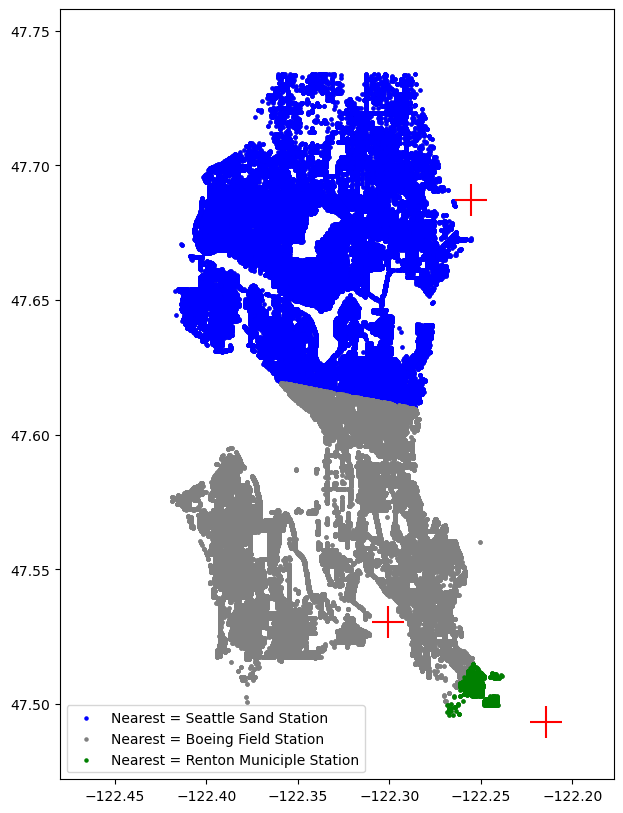

In [44]:
#Create a plot, splitting out the different points by color for their different closest stations.
fig, ax = plt.subplots(figsize = (10,10))
trees_geo_df.plot(ax=ax, markersize=5, color='gray', marker='o')
trees_geo_df[trees_geo_df['nearest_station'] == 'USW00094290'].plot(ax=ax, markersize=5, color='blue', marker='o', label='Nearest = Seattle Sand Station')
trees_geo_df[trees_geo_df['nearest_station'] == 'USW00024234'].plot(ax=ax, markersize=5, color='gray', marker='o', label='Nearest = Boeing Field Station') 
trees_geo_df[trees_geo_df['nearest_station'] == 'USW00094248'].plot(ax=ax, markersize=5, color='green', marker='o', label='Nearest = Renton Municiple Station')

stations_geo_df.plot(ax=ax, markersize=500, color='red', marker='+')

#zoom into rough seattle area by adding some space around the min and max values
plt.axis([trees_data['long_trees'].min()*1.0005, trees_data['long_trees'].max()*.9995, trees_data['lat_trees'].min()*0.9995, trees_data['lat_trees'].max()*1.0005])
plt.legend()

plt.show()